### Decision Tree Lab 

##### Rachel Seo ydp7xv

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz 

from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz 

In [2]:
# data loading
movie_metadata=pd.read_csv("../data/movie_metadata.csv")

In [ ]:
# total function 
def cleaning(df):
    # drop irrelevant columns
    columns = ['duration', 'actor_3_facebook_likes', 'facenumber_in_poster', 'actor_2_facebook_likes', 'aspect_ratio', 'color',
           'actor_2_name', 'actor_3_name', 'plot_keywords', 'movie_imdb_link', 'language', 'director_name', 'title_year', 'actor_1_name', 'movie_title']
    df.drop(columns=columns, inplace=True)

    def parse_genres(genres):
        if isinstance(genres, str):  # checking if genres is a string
            # split the string by '|' and return the first genre
            return genres.split('|')[0].strip()
        elif isinstance(genres, list) and len(genres) > 0:  # if it's already a list, return the first element
            return genres[0]
        else:
            return None  # return None if the value is not a string or a non-empty list
    df['genres'] = df['genres'].apply(parse_genres)

    # collapsing country 
    top_countries = ['USA', 'UK']
    df.country = (df.country.apply(lambda x: x if x in top_countries else "Other")).astype('category')

    # collapsing genres
    top_genres = ['Comedy', 'Action']
    df.genres = (df.genres.apply(lambda x: x if x in top_genres else "Other")).astype('category')

    # collapsing content ratings 
    top_ratings = ['R', 'PG-13']
    df['content_rating'] = df['content_rating'].apply(lambda x: x if x in top_ratings else 'Other').astype('category')

    # dropping null values
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [4]:
# testing the function
df = cleaning(movie_metadata)

df.head()

,num_critic_for_reviews,director_facebook_likes,actor_1_facebook_likes,gross,genres,num_voted_users,cast_total_facebook_likes,num_user_for_reviews,country,content_rating,budget,imdb_score,movie_facebook_likes
0,723.0,0.0,1000.0,760505847.0,Action,886204,4834,3054.0,USA,PG-13,237000000.0,7.9,33000
1,302.0,563.0,40000.0,309404152.0,Action,471220,48350,1238.0,USA,PG-13,300000000.0,7.1,0
2,602.0,0.0,11000.0,200074175.0,Action,275868,11700,994.0,UK,PG-13,245000000.0,6.8,85000
3,813.0,22000.0,27000.0,448130642.0,Action,1144337,106759,2701.0,USA,PG-13,250000000.0,8.5,164000
4,462.0,475.0,640.0,73058679.0,Action,212204,1873,738.0,USA,PG-13,263700000.0,6.6,24000


In [5]:
# cut imdb_score into 1 and 0 from top 25% percentile 

def cut_imdb_score(df):
    # calculate the 75th percentile
    percentile_75 = df['imdb_score'].quantile(0.75)
    
    # create a new column 'top_imdb_score'
    df['top_imdb_score'] = np.where(df['imdb_score'] >= percentile_75, 1, 0)
    
    return df
# applying the cut function
df = cut_imdb_score(df)

df.drop(columns=['imdb_score'], inplace=True)
df['top_imdb_score'] = df['top_imdb_score'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3887 entries, 0 to 3886
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   num_critic_for_reviews     3887 non-null   float64 
 1   director_facebook_likes    3887 non-null   float64 
 2   actor_1_facebook_likes     3887 non-null   float64 
 3   gross                      3887 non-null   float64 
 4   genres                     3887 non-null   category
 5   num_voted_users            3887 non-null   int64   
 6   cast_total_facebook_likes  3887 non-null   int64   
 7   num_user_for_reviews       3887 non-null   float64 
 8   country                    3887 non-null   category
 9   content_rating             3887 non-null   category
 10  budget                     3887 non-null   float64 
 11  movie_facebook_likes       3887 non-null   int64   
 12  top_imdb_score             3887 non-null   category
dtypes: category(4), float64(6), int64

In [ ]:
# collapsing/encoding target variable
df[["top_imdb_score"]] = OrdinalEncoder().fit_transform(df[["top_imdb_score"]])
print(df["top_imdb_score"].value_counts())

top_imdb_score
0.0    2849
1.0    1038
Name: count, dtype: int64


In [7]:
# prevalence for the target variable
print(1038/(2849+1038))

# The prevalence of the target variable represents the proportion of positive cases (1s) in the dataset. 
# In this case, the prevalence is approximately 26.7%, meaning that about 26.7% of the movies in the dataset have a high IMDb score (top 25%).
# This is a relatively imbalanced dataset, as there are significantly more movies with lower IMDb scores (0s) compared to those with higher scores (1s).

0.26704399279650115


In [8]:
# one-hot encoding
categorical_columns = df.select_dtypes(include=['category']).columns
df2 = pd.get_dummies(df, columns=categorical_columns)

In [9]:
# splitting the dataset into test, tune, and train sets (80% train, 10% tune, 10% test)

X = df2.drop(columns=['top_imdb_score'])
y = df2.top_imdb_score

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, stratify= y, random_state=21)
X_tune, X_test, y_tune, y_test = train_test_split(X_test,y_test,  train_size = 0.5,stratify= y_test, random_state=49)

In [10]:
# kfold object for cross validation

kf = RepeatedStratifiedKFold(n_splits=10,n_repeats=5, random_state=42)

In [ ]:
# scoring metric and the max depth hyperparameter (grid search) 
scoring = 'f1_weighted'
param = {"max_depth" : [1,2,3,4,5,6,7,8,9,10,11]}

In [20]:
# fitting model to training data
cl= DecisionTreeClassifier(random_state=1000)

# search for best DecisionTreeClassifier estimator across all folds based f1_weighted
search = GridSearchCV(cl, param, scoring=scoring, n_jobs=-1, cv=kf,refit='f1_weighted')

# execute on training data
model = search.fit(X_train, y_train)

# best hyperparameters and score
best = model.best_estimator_
print(best) 

DecisionTreeClassifier(max_depth=5, random_state=1000)


In [21]:
print(model.cv_results_)

{'mean_fit_time': array([0.00599154, 0.00637001, 0.00902311, 0.01069516, 0.0240674 ,
       0.02376858, 0.01901168, 0.02234075, 0.02186903, 0.02360387,
       0.02218844]), 'std_fit_time': array([0.00384139, 0.00151078, 0.00265918, 0.00275534, 0.03099314,
       0.03075041, 0.00523244, 0.00793723, 0.0048614 , 0.0069692 ,
       0.00379263]), 'mean_score_time': array([0.00297658, 0.00277548, 0.00271116, 0.0021243 , 0.00752132,
       0.00754554, 0.00316987, 0.00321513, 0.00247466, 0.00261261,
       0.00209895]), 'std_score_time': array([0.00207494, 0.00153492, 0.00153181, 0.00102473, 0.01694887,
       0.02312028, 0.00206231, 0.00221479, 0.00163611, 0.00161145,
       0.00119984]), 'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value=999999), 'params': [{'max_depth': 1}, {'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_dep

In [22]:
# extracting scores to view model

# scores: 
f1_w = model.cv_results_['mean_test_score']
SD_f1_w = model.cv_results_['std_test_score']

# parameter:
depth= np.unique(model.cv_results_['param_max_depth']).data

# building dataframe
final_model = pd.DataFrame(list(zip(depth, 
                                    f1_w, 
                                    SD_f1_w)),
                           columns=['depth', 'f1_weighted', 'f1_weightedSD'])

# final model
final_model.style.hide(axis='index')

# The model seems to be performing well with the metrics that I have chosen. 

depth,f1_weighted,f1_weightedSD
1,0.753107,0.023325
2,0.753324,0.021350
3,0.786010,0.021802
4,0.788463,0.019326
5,0.794892,0.019314
6,0.793390,0.020623
7,0.792442,0.020703
8,0.789173,0.020162
9,0.788005,0.023603
10,0.783608,0.020250


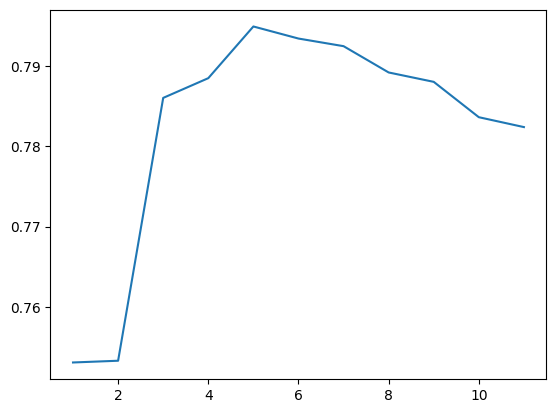

In [23]:
# checking the depth
print(plt.plot(final_model.depth,final_model.f1_weighted))

In [ ]:
# variable importance
varimp = pd.DataFrame(best.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance', ascending=False)
print(varimp)

# num_voted_users and genres_others seem to have the most importance

                           importance
num_voted_users              0.559471
genres_Other                 0.108349
budget                       0.106753
cast_total_facebook_likes    0.076477
gross                        0.050940
director_facebook_likes      0.039727
country_USA                  0.031240
num_critic_for_reviews       0.016529
num_user_for_reviews         0.005857
actor_1_facebook_likes       0.004656
country_UK                   0.000000
content_rating_PG-13         0.000000
content_rating_Other         0.000000
genres_Action                0.000000
country_Other                0.000000
genres_Comedy                0.000000
movie_facebook_likes         0.000000
content_rating_R             0.000000


In [ ]:
# predicting on tuning data
y_tune_pred = model.best_estimator_.predict(X_tune)

# printing predictions
print("Predictions on Tune Data:")
print(y_tune_pred)

# evaluating performance
from sklearn.metrics import f1_score
f1_tune = f1_score(y_tune, y_tune_pred, average='weighted')
print("\nF1-Weighted Score on Tune Data:", f1_tune)

# The model's performance increased on the tuning set.

Predictions on Tune Data:
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 

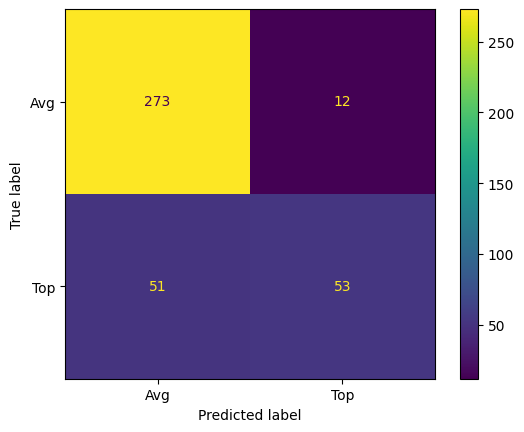

In [ ]:
# confusion matrix
print(ConfusionMatrixDisplay.from_estimator(best,X_tune,y_tune, display_labels = 
                                            ['Avg','Top'], colorbar=True))

# This confusion matrix is telling me that the model performed well in predicting most of the
# average movies (0s) correctly, with only a few false positives (1s predicted as 0s).

# The model also correctly identified a good number of top-rated movies (1s)
# but there were some false negatives (0s predicted as 1s).

In [37]:
# top three movies 
tune_data = X_tune.copy()
tune_data['top_imdb_score'] = y_tune 

top_movies = tune_data.sort_values(by='top_imdb_score', ascending=False)

# Unfortunately, when I was cleaning in the first part, I removed the movie titles.
# Merging the original dataset to get the movie titles back.

mm = pd.read_csv("../data/movie_metadata.csv")

if 'movie_title' in mm.columns:
	top_movies = top_movies.merge(mm[['movie_title']], left_index=True, right_index=True, how='left')
	top_movies = top_movies[['movie_title', 'top_imdb_score']]
	print("Top 3 Movies with Highest IMDb Scores:")
	print(top_movies.sort_values(by='top_imdb_score', ascending=False).head(3))

Top 3 Movies with Highest IMDb Scores:
      movie_title  top_imdb_score
3392        Prom              1.0
490     The Edge              1.0
1352  Angel Eyes              1.0


In [38]:
# different hyperparameter

scoring = 'f1_weighted'
param2 = {"criterion" : ['gini', 'entropy']}

# fitting model
cl2= DecisionTreeClassifier(random_state=1000)

# search for best DecisionTreeClassifier estimator across all folds based f1_weighted
search2 = GridSearchCV(cl2, param2, scoring=scoring, n_jobs=-1, cv=kf,refit='f1_weighted')

# execute on training data
model2 = search2.fit(X_train, y_train)

# best hyperparameters and score
best2 = model2.best_estimator_
print(best2) 

DecisionTreeClassifier(criterion='entropy', random_state=1000)


In [ ]:
# extracting scores to view model

# scores: 
f1_w = model2.cv_results_['mean_test_score']
SD_f1_w = model2.cv_results_['std_test_score']

# parameter:
crit = np.unique(model2.cv_results_['param_criterion']).data

# building dataframe
final_model2 = pd.DataFrame(list(zip(depth, 
                                    f1_w, 
                                    SD_f1_w)),
                           columns=['crit', 'f1_weighted', 'f1_weightedSD'])

# final model
final_model2.style.hide(axis='index')

# The model performed well but not better than my first model with max_depth as the hyperparameter.

crit,f1_weighted,f1_weightedSD
1,0.771416,0.021339
2,0.773903,0.026886


In [ ]:
# predicting test data 
y_test_pred = model.best_estimator_.predict(X_test)

# printing predictions
print("Predictions on Test Data:")
print(y_test_pred)

# evaluating performance
f1_test = f1_score(y_test, y_test_pred, average='weighted')
print("\nF1-Weighted Score on Test Data:", f1_test)

# The F1-Weighted Score on the test data is approx 0.836, which indicates that the model is performing well on unseen data.

Predictions on Test Data:
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 

**Final Recommendation:**

The Decision Tree Classification Model can be used to predict movie success based on the features provided. I learned that I need to one-hot-encode my categorical variables because the sci-kit learn package only takes numerical variables to make decisions and that I need to collapse my target variable to also be numeric. 


My model's accuracy on the test data is higher than usual, but this is also because I dropped some features that I believed were not relevant. However, everyone's idea of a "good" movie is different so it is truly difficult to determine a final recommendation. But for now, my final recommendation would be to use this model to predict movie success if there is a large number of votes and a genre that is not in the 'Comedy' or 'Action' category.
